In [45]:
!pip install geopandas matplotlib shapely pandas networkx seaborn python-louvain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.6/204.6 kB 1.3 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for python-louvain: filename=python_louvain-0.16-py3-none-any.whl size=9389 sha256=9a3efbc0719fadcd67658f856ab89c68f46be3de4a83f341105a2ee1c6ff05cc
  Stored in directory: /home/benjamin/.cache/pip/wheels/40/f1/e3/485b698c520fa0baee1d07897abc7b8d6479b7d199ce96f4af
Successfully built python-louvain


In [46]:
import pandas as pd

# Replace 'amazon_fine_foods_reviews.csv' with the path to your CSV file
csv_file = '../data/normalized_data.csv'

# Load the CSV file into a pandas DataFrame
df = pd.read_csv(csv_file)

In [47]:
# Display the first few rows of the DataFrame
df.head(5)

title  magnitude         date_time  cdi  \
0          M 6.5 - 42 km W of Sola, Vanuatu        6.5  16-08-2023 12:47    7   
1  M 6.5 - 43 km S of Intipucá, El Salvador        6.5  19-07-2023 00:22    8   
2  M 6.6 - 25 km ESE of Loncopué, Argentina        6.6  17-07-2023 03:05    7   
3     M 7.2 - 98 km S of Sand Point, Alaska        7.2  16-07-2023 06:48    6   
4                  M 7.3 - Alaska Peninsula        7.3  16-07-2023 06:48    0   

   mmi  alert  tsunami  sig net  nst      dmin    gap  magType    depth  \
0    4      4        0  657  us  114  7.177000   25.0        0  192.955   
1    6      2        0  775  us   92  0.679000   40.0        0   69.727   
2    5      4        0  899  us   70  1.634000   28.0        0  171.371   
3    6      4        1  860  us  173  0.907000   36.0        0   32.571   
4    5      0        1  820  at   79  0.879451  172.8        1   21.000   

   latitude  longitude  
0     -14.0      167.0  
1      13.0      -88.0  
2     -38.0      -70.0  
3      54.0     -161.0  
4      54.0     -161.0

In [48]:
# Display info of the data set
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   title      1000 non-null   object 
 1   magnitude  1000 non-null   float64
 2   date_time  1000 non-null   object 
 3   cdi        1000 non-null   int64  
 4   mmi        1000 non-null   int64  
 5   alert      1000 non-null   int64  
 6   tsunami    1000 non-null   int64  
 7   sig        1000 non-null   int64  
 8   net        1000 non-null   object 
 9   nst        1000 non-null   int64  
 10  dmin       1000 non-null   float64
 11  gap        1000 non-null   float64
 12  magType    1000 non-null   int64  
 13  depth      1000 non-null   float64
 14  latitude   1000 non-null   float64
 15  longitude  1000 non-null   float64
dtypes: float64(6), int64(7), object(3)
memory usage: 125.1+ KB


In [49]:
# Ensure 'date_time' column is in datetime format
df['date_time'] = pd.to_datetime(df['date_time'], errors='coerce')

# Define periods
periods = {
    '1995-2002': (1995, 2002),
    '2003-2010': (2003, 2010),
    '2011-2017': (2011, 2017),
    '2018-2023': (2018, 2023)
}

# Initialize dictionary to store data by period
data_by_period = {}

# Filter data for each period
for period, (start_year, end_year) in periods.items():
    data_by_period[period] = df[(df['date_time'].dt.year >= start_year) & (df['date_time'].dt.year <= end_year)]

# Print the number of records for each period
for period, data in data_by_period.items():
    print(f'Period: {period}, Number of records: {len(data)}')

Period: 1995-2002, Number of records: 236
Period: 2003-2010, Number of records: 246
Period: 2011-2017, Number of records: 298
Period: 2018-2023, Number of records: 220


/tmp/ipykernel_18100/3293340679.py:2: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['date_time'] = pd.to_datetime(df['date_time'], errors='coerce')


In [50]:
from math import radians, sin, cos, sqrt, atan2

def haversine(lat1, lon1, lat2, lon2):
    # Earth radius in kilometers
    R = 6371.0

    # Convert latitude and longitude from degrees to radians
    lat1_rad = radians(lat1)
    lon1_rad = radians(lon1)
    lat2_rad = radians(lat2)
    lon2_rad = radians(lon2)

    # Differences in coordinates
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad

    # Haversine formula
    a = sin(dlat / 2)**2 + cos(lat1_rad) * cos(lat2_rad) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c

    return distance

In [51]:
import networkx as nx

keys_list = list(data_by_period.keys())
graphs = {}

for i in range(len(keys_list)):
    period = keys_list[i]
    current_df = data_by_period[period]

    # Initialize a graph
    G = nx.Graph()

    # Add nodes to the graph
    for index, row in current_df.iterrows():
        G.add_node(
            index,
            title=row['title'],
            magnitude=row['magnitude'],
            date_time=row['date_time'],
            cdi=row['cdi'],
            mmi=row['mmi'],
            alert=row['alert'],
            tsunami=row['tsunami'],
            sig=row['sig'],
            net=row['net'],
            nst=row['nst'],
            dmin=row['dmin'],
            gap=row['gap'],
            magType=row['magType'],
            depth=row['depth'],
            latitude=row['latitude'],
            longitude=row['longitude']
        )

    # Add edges with weight based on distance using actual indices
    for i in current_df.index:
        for j in current_df.index:
            if i < j:
                lat1, lon1 = current_df.loc[i, 'latitude'], current_df.loc[i, 'longitude']
                lat2, lon2 = current_df.loc[j, 'latitude'], current_df.loc[j, 'longitude']

                # Calculate the distance between two points (lat1, lon1) and (lat2, lon2) using the Haversine formula
                # The distance is returned in kilometers
                distance = haversine(lat1, lon1, lat2, lon2)

                # If the distance is 0 (meaning the points are the same), set the weight to 1
                if distance == 0 :
                    weight = 1
                    # Add an edge between nodes i and j with the specified weight
                    G.add_edge(i, j, weight=weight)

                # If the distance is less than 1000 kilometers and not zero
                if  distance < 1000 and distance !=0 :
                    # Calculate the weight as the inverse of the distance
                    weight = 1 / distance
                    # Add an edge between nodes i and j with the specified weight
                    G.add_edge(i, j, weight=weight)

    # Store the graph in the dictionary
    graphs[period] = G

print("Graphs have been created for all periods.")

Graphs have been created for all periods.


In [52]:
import os
import pandas as pd

# Directory path where the GraphML files will be saved
directory = "gephi_exports"

# Create the directory if it doesn't exist
if not os.path.exists(directory):
    os.makedirs(directory)

# Convert Timestamp objects to strings in node and edge attributes
def convert_timestamps_to_strings(graph):
    # Convert node attributes
    for node, data in graph.nodes(data=True):
        for key, value in data.items():
            if isinstance(value, pd.Timestamp):
                data[key] = value.isoformat()  # Convert to ISO 8601 string

    # Convert edge attributes
    for u, v, data in graph.edges(data=True):
        for key, value in data.items():
            if isinstance(value, pd.Timestamp):
                data[key] = value.isoformat()  # Convert to ISO 8601 string

# Save each graph to a GraphML file with a period-based filename
for period, G in graphs.items():
    convert_timestamps_to_strings(G)  # Convert timestamps to strings
    filename = f"earthquake_{period.replace(' ', '_').replace('-', '_')}.graphml"
    file_path = os.path.join(directory, filename)
    nx.write_graphml(G, file_path)
    print(f"Graph for period '{period}' saved as '{filename}'")

Graph for period '1995-2002' saved as 'earthquake_1995_2002.graphml'
Graph for period '2003-2010' saved as 'earthquake_2003_2010.graphml'
Graph for period '2011-2017' saved as 'earthquake_2011_2017.graphml'
Graph for period '2018-2023' saved as 'earthquake_2018_2023.graphml'


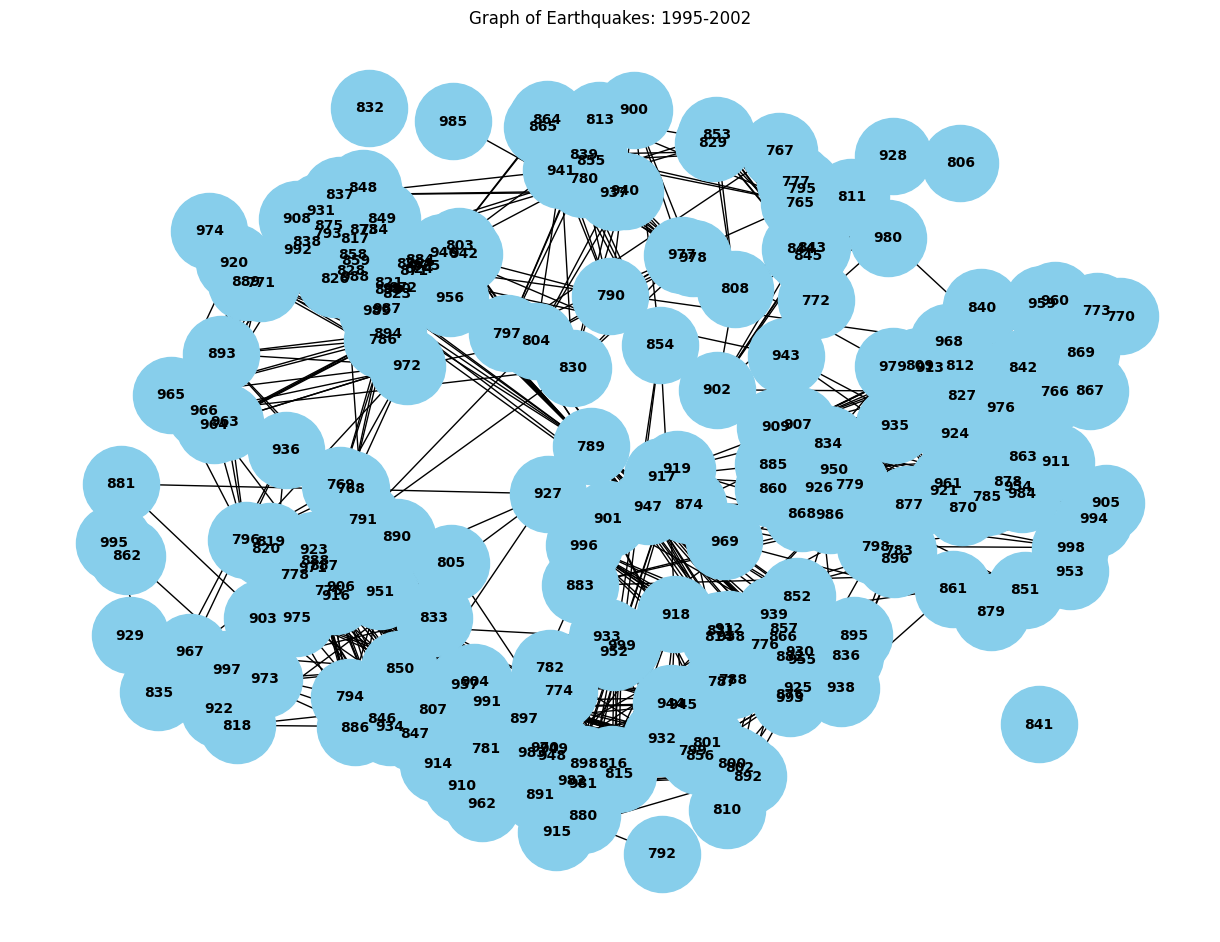

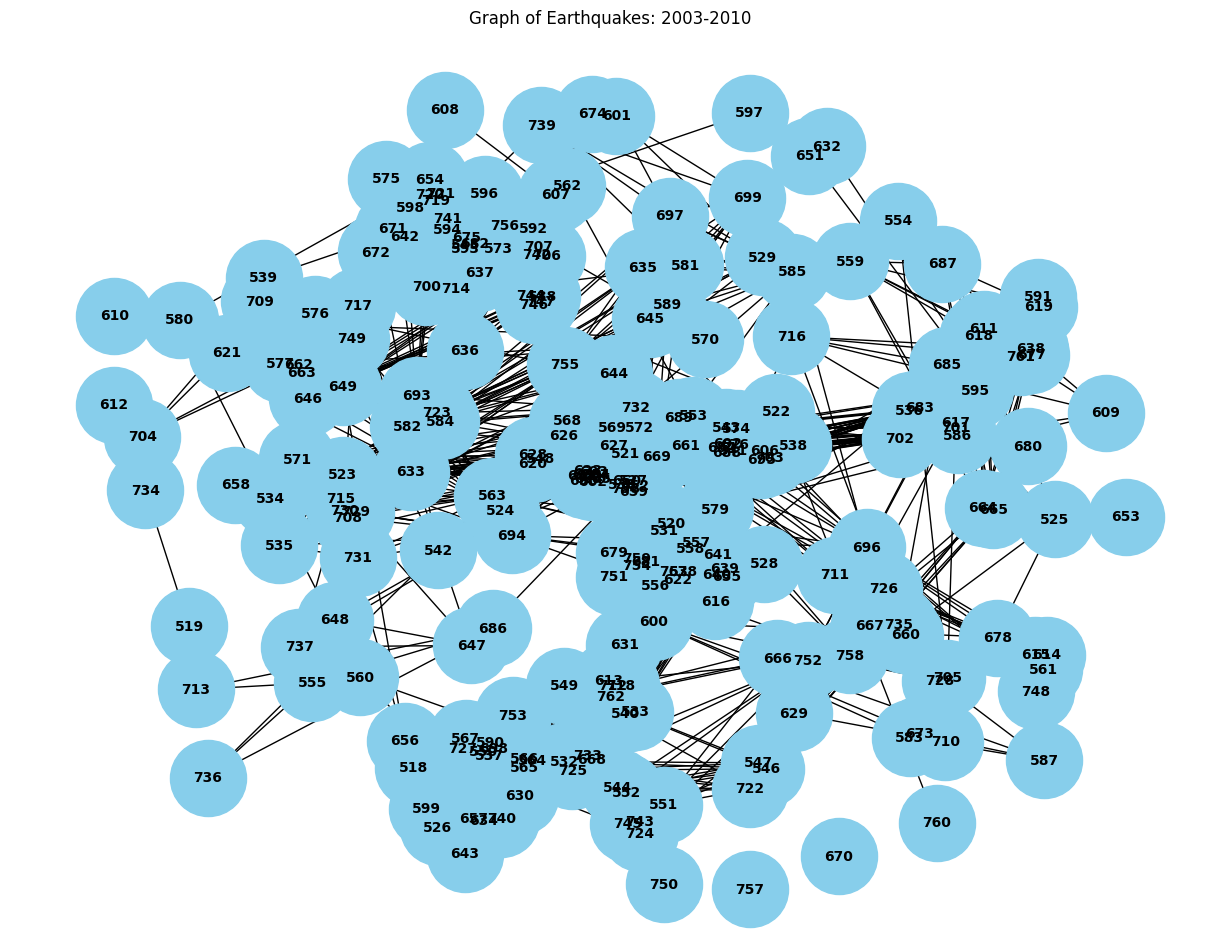

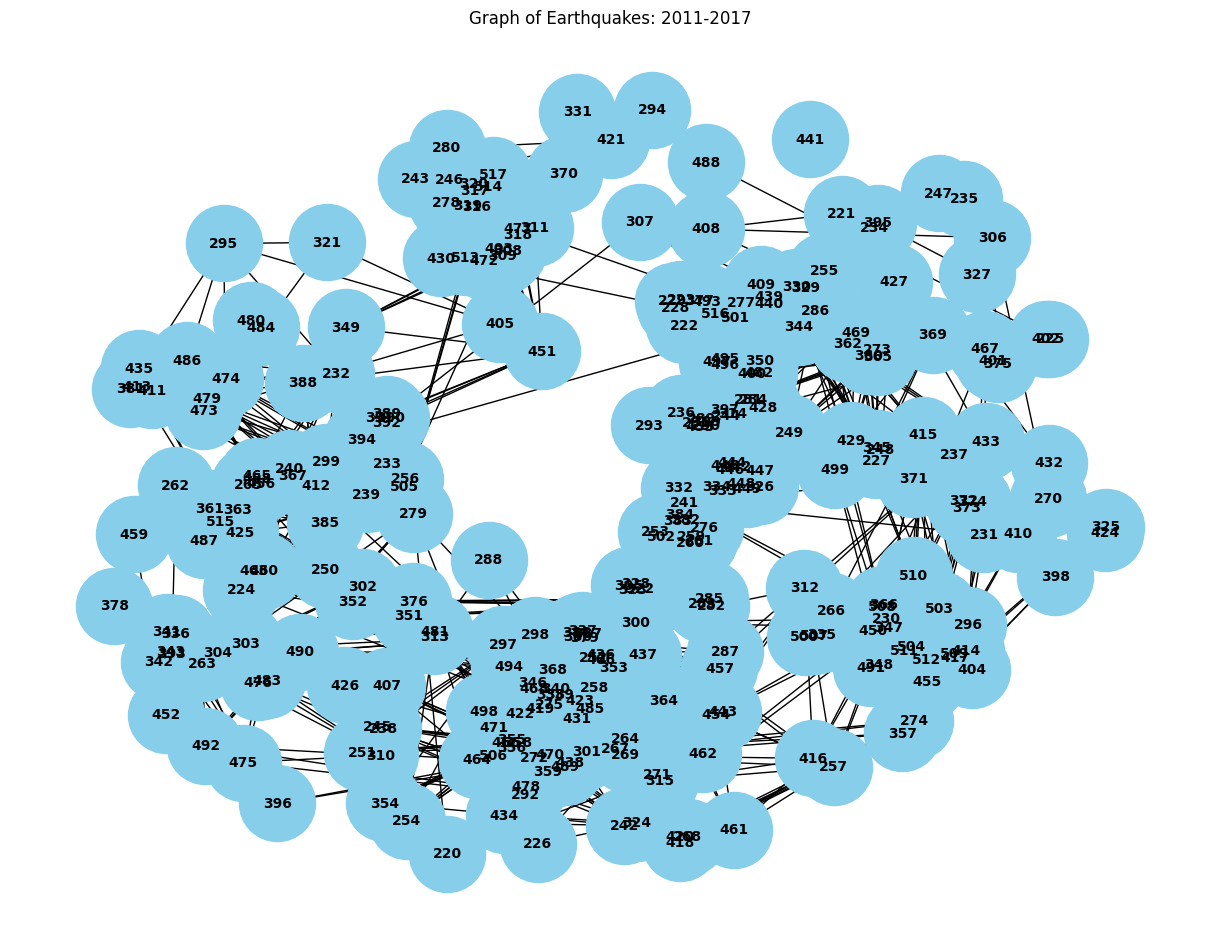

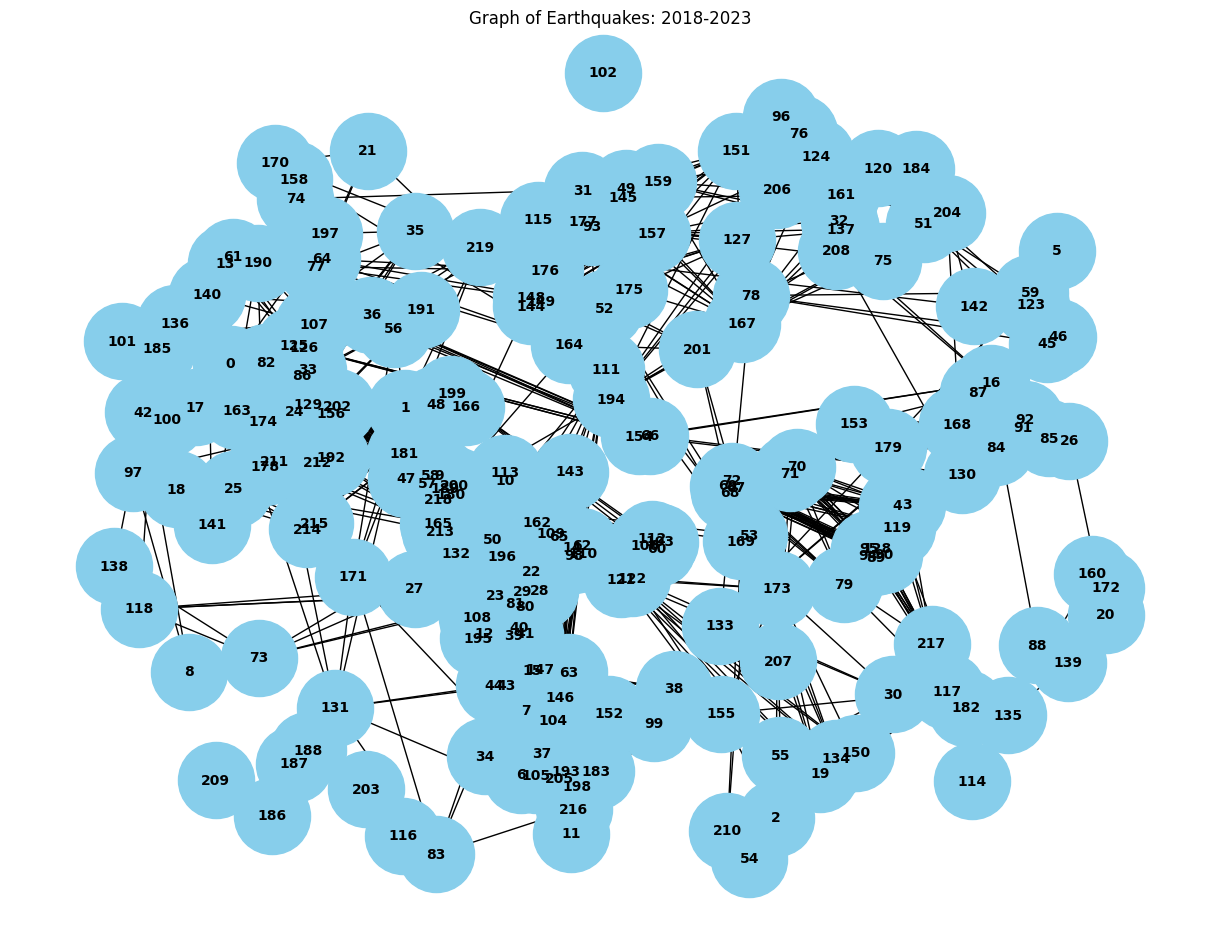

In [53]:
import matplotlib.pyplot as plt

# Plot each graph with a header indicating the period
for period, G in graphs.items():
    pos = nx.spring_layout(G)  # Calculate positions for nodes
    plt.figure(figsize=(12, 9))  # Set the figure size
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=3000, font_size=10, font_weight='bold')
    plt.title(f'Graph of Earthquakes: {period}')  # Set the title with the period
    plt.show()  # Display the graph

In [54]:
def analyze_degrees(graph):
    # Calculate the degree for all nodes
    degrees = dict(graph.degree())
    return degrees

# Function to analyze paths in the graph
def analyze_paths(graph):
    path_lengths = {}
    for node in graph.nodes():
        lengths = nx.single_source_shortest_path_length(graph, node)
        path_lengths[node] = lengths
    return path_lengths

# Analyze degrees and paths for each graph
for period, G in graphs.items():
    # Calculate degrees (since the graph is undirected)
    degrees = analyze_degrees(G)
    print(f'Period: {period} - Degrees: {degrees}')

    # Calculate path lengths
    path_lengths = analyze_paths(G)
    print(f'Period: {period} - Path Lengths: {path_lengths}')


Period: 1995-2002 - Degrees: {764: 30, 765: 5, 766: 2, 767: 5, 768: 15, 769: 15, 770: 0, 771: 18, 772: 3, 773: 9, 774: 4, 775: 10, 776: 18, 777: 3, 778: 11, 779: 11, 780: 8, 781: 15, 782: 18, 783: 6, 784: 32, 785: 7, 786: 17, 787: 17, 788: 17, 789: 25, 790: 8, 791: 8, 792: 1, 793: 34, 794: 15, 795: 3, 796: 15, 797: 5, 798: 7, 799: 12, 800: 14, 801: 12, 802: 14, 803: 30, 804: 9, 805: 17, 806: 0, 807: 25, 808: 8, 809: 13, 810: 1, 811: 8, 812: 10, 813: 5, 814: 19, 815: 13, 816: 13, 817: 30, 818: 5, 819: 4, 820: 4, 821: 31, 822: 30, 823: 31, 824: 30, 825: 30, 826: 31, 827: 5, 828: 30, 829: 8, 830: 9, 831: 19, 832: 0, 833: 18, 834: 11, 835: 5, 836: 18, 837: 7, 838: 31, 839: 5, 840: 1, 841: 0, 842: 1, 843: 8, 844: 8, 845: 8, 846: 15, 847: 20, 848: 22, 849: 32, 850: 6, 851: 4, 852: 16, 853: 8, 854: 9, 855: 5, 856: 12, 857: 18, 858: 34, 859: 34, 860: 7, 861: 6, 862: 0, 863: 16, 864: 6, 865: 6, 866: 18, 867: 10, 868: 7, 869: 10, 870: 15, 871: 30, 872: 31, 873: 32, 874: 4, 875: 34, 876: 12, 877:

Period: 1995-2002 - Mean Degree: 12.42, Std Dev: 8.99, Min Degree: 0, Max Degree: 35
Period: 2003-2010 - Mean Degree: 15.43, Std Dev: 10.32, Min Degree: 0, Max Degree: 36
Period: 2011-2017 - Mean Degree: 15.68, Std Dev: 12.31, Min Degree: 0, Max Degree: 42
Period: 2018-2023 - Mean Degree: 11.62, Std Dev: 9.07, Min Degree: 0, Max Degree: 42


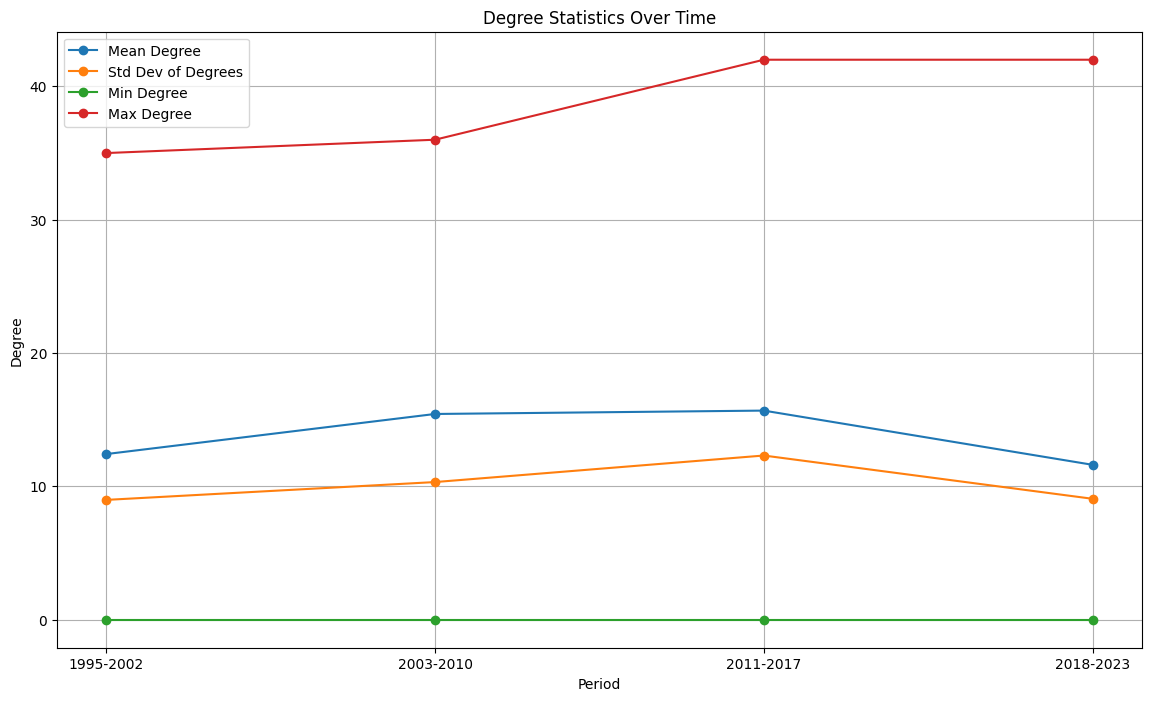

In [55]:
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate statistics
def calculate_statistics(degrees):
    degree_values = list(degrees.values())
    mean_degree = np.mean(degree_values)
    std_dev_degree = np.std(degree_values)
    min_degree = np.min(degree_values)
    max_degree = np.max(degree_values)
    return mean_degree, std_dev_degree, min_degree, max_degree

# Analyze degrees and paths for each graph and calculate statistics
degree_stats = {}

for period, G in graphs.items():
    # Calculate degrees
    degrees = analyze_degrees(G)

    # Calculate statistics
    mean_degree, std_dev_degree, min_degree, max_degree = calculate_statistics(degrees)

    # Store statistics for later analysis
    degree_stats[period] = {
        'mean': mean_degree,
        'std_dev': std_dev_degree,
        'min': min_degree,
        'max': max_degree
    }

    print(f'Period: {period} - Mean Degree: {mean_degree:.2f}, Std Dev: {std_dev_degree:.2f}, Min Degree: {min_degree}, Max Degree: {max_degree}')

# Plotting the statistics to visualize trends
periods = list(degree_stats.keys())
means = [degree_stats[period]['mean'] for period in periods]
std_devs = [degree_stats[period]['std_dev'] for period in periods]
mins = [degree_stats[period]['min'] for period in periods]
maxs = [degree_stats[period]['max'] for period in periods]

plt.figure(figsize=(14, 8))
plt.plot(periods, means, marker='o', label='Mean Degree')
plt.plot(periods, std_devs, marker='o', label='Std Dev of Degrees')
plt.plot(periods, mins, marker='o', label='Min Degree')
plt.plot(periods, maxs, marker='o', label='Max Degree')
plt.xlabel('Period')
plt.ylabel('Degree')
plt.title('Degree Statistics Over Time')
plt.legend()
plt.grid(True)
plt.show()


In [56]:
# Function to compute centrality measures
def compute_centrality_measures(graph):
    # Compute centrality measures
    edge_degrees = dict(graph.degree())
    closeness_centrality = nx.closeness_centrality(graph)
    betweenness_centrality = nx.betweenness_centrality(graph)
    eigenvector_centrality = nx.eigenvector_centrality(graph)

    return edge_degrees, closeness_centrality, betweenness_centrality, eigenvector_centrality

# Function to get top 10 nodes based on centrality measure
def get_top_n_nodes(centrality_dict ,n):
    sorted_nodes = sorted(centrality_dict.items(), key=lambda x: x[1], reverse=True)
    return sorted_nodes[:n]

In [57]:
# Set the number of top nodes u want to get
top_n = 5

# Use a set to track unique nodes
top_nodes = set()

# Analyze centralities for each period and print the top 10 nodes
for period, G in graphs.items():
    print(f'\nPeriod: {period}')

    # Compute centrality measures
    edge_degrees, closeness, betweenness, eigenvector = compute_centrality_measures(G)

    # Get top n nodes for each centrality measure
    top_n_edge_degrees = get_top_n_nodes(edge_degrees,top_n)
    top_n_closeness = get_top_n_nodes(closeness,top_n)
    top_n_betweenness = get_top_n_nodes(betweenness,top_n)
    top_n_eigenvector = get_top_n_nodes(eigenvector,top_n)



    # Print top `top_n` nodes for each centrality measure
    print(f"Top {top_n} nodes by edge degree:")
    for node, degree in top_n_edge_degrees:
        print(f"Node: {node}, Edge Degree: {degree}")
        top_nodes.add(node)  # Add node to the set

    print(f"\nTop {top_n} nodes by closeness centrality:")
    for node, centrality in top_n_closeness:
        print(f"Node: {node}, Closeness Centrality: {centrality}")
        top_nodes.add(node)  # Add node to the set

    print(f"\nTop {top_n} nodes by betweenness centrality:")
    for node, centrality in top_n_betweenness:
        print(f"Node: {node}, Betweenness Centrality: {centrality}")
        top_nodes.add(node)  # Add node to the set


    print(f"\nTop {top_n} nodes by eigenvector centrality:")
    for node, centrality in top_n_eigenvector:
        print(f"Node: {node}, Eigenvector Centrality: {centrality}")
        top_nodes.add(node)  # Add node to the set


Period: 1995-2002
Top 5 nodes by edge degree:
Node: 908, Edge Degree: 35
Node: 793, Edge Degree: 34
Node: 858, Edge Degree: 34
Node: 859, Edge Degree: 34
Node: 875, Edge Degree: 34

Top 5 nodes by closeness centrality:
Node: 972, Closeness Centrality: 0.13792951784045301
Node: 893, Closeness Centrality: 0.1368685215493726
Node: 796, Closeness Centrality: 0.13617021276595745
Node: 908, Closeness Centrality: 0.13479475607135183
Node: 931, Closeness Centrality: 0.1344552226807439

Top 5 nodes by betweenness centrality:
Node: 854, Betweenness Centrality: 0.07201309328968902
Node: 796, Betweenness Centrality: 0.06467824288453393
Node: 891, Betweenness Centrality: 0.06114607901259233
Node: 789, Betweenness Centrality: 0.04046216706576428
Node: 972, Betweenness Centrality: 0.039796936730750174

Top 5 nodes by eigenvector centrality:
Node: 908, Eigenvector Centrality: 0.18609579936158402
Node: 793, Eigenvector Centrality: 0.18520122745778725
Node: 858, Eigenvector Centrality: 0.18520122745778

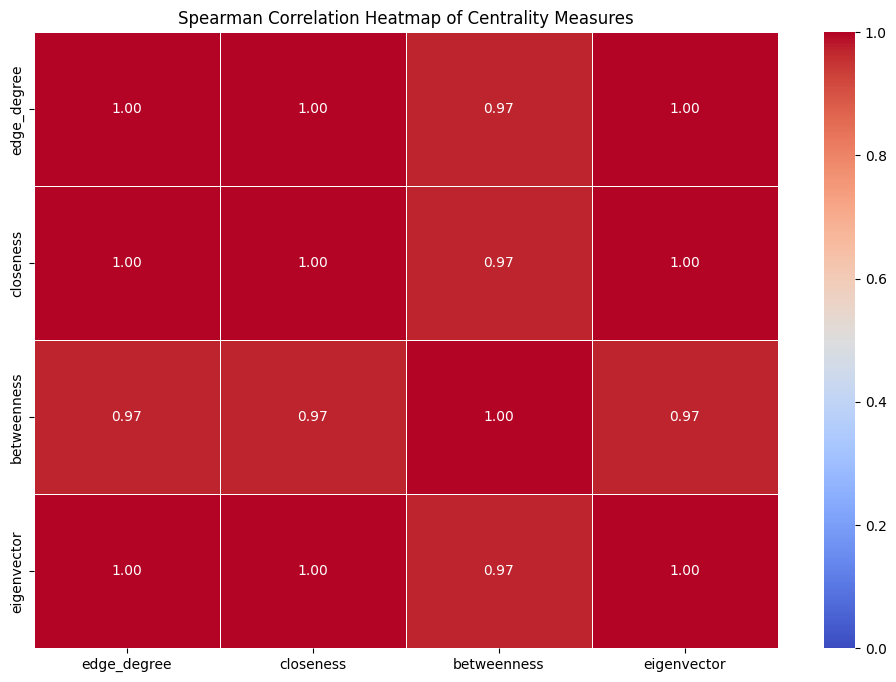

In [58]:
import seaborn as sns

# Filter the DataFrame based on the indices
filtered_df = df.loc[df.index[df.index.isin(top_nodes)]]

# Drop the 'title' and 'net' columns from the filtered DataFrame
filtered_df = filtered_df.drop(columns=['title', 'net'])

# Create columns for each centrality measure if they don't exist
centrality_measures = ['edge_degree', 'closeness', 'betweenness', 'eigenvector']
for measure in centrality_measures:
    if measure not in filtered_df.columns:
        filtered_df[measure] = 0.0

# Fill the columns with the appropriate values
for node in filtered_df.index:
    filtered_df.at[node, 'edge_degree'] = edge_degrees.get(node, 0)
    filtered_df.at[node, 'closeness'] = closeness.get(node, 0)
    filtered_df.at[node, 'betweenness'] = betweenness.get(node, 0)
    filtered_df.at[node, 'eigenvector'] = eigenvector.get(node, 0)

# Filter the DataFrame to include only centrality measure columns
filtered_df_centrality = filtered_df[centrality_measures]

# Calculate the Spearman correlation matrix
spearman_corr = filtered_df_centrality.corr(method='spearman')

# Plot the heatmap of the Spearman correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(spearman_corr, annot=True, cmap='coolwarm', vmin=0, vmax=1, fmt=".2f", linewidths=0.5)
plt.title('Spearman Correlation Heatmap of Centrality Measures')
plt.show()

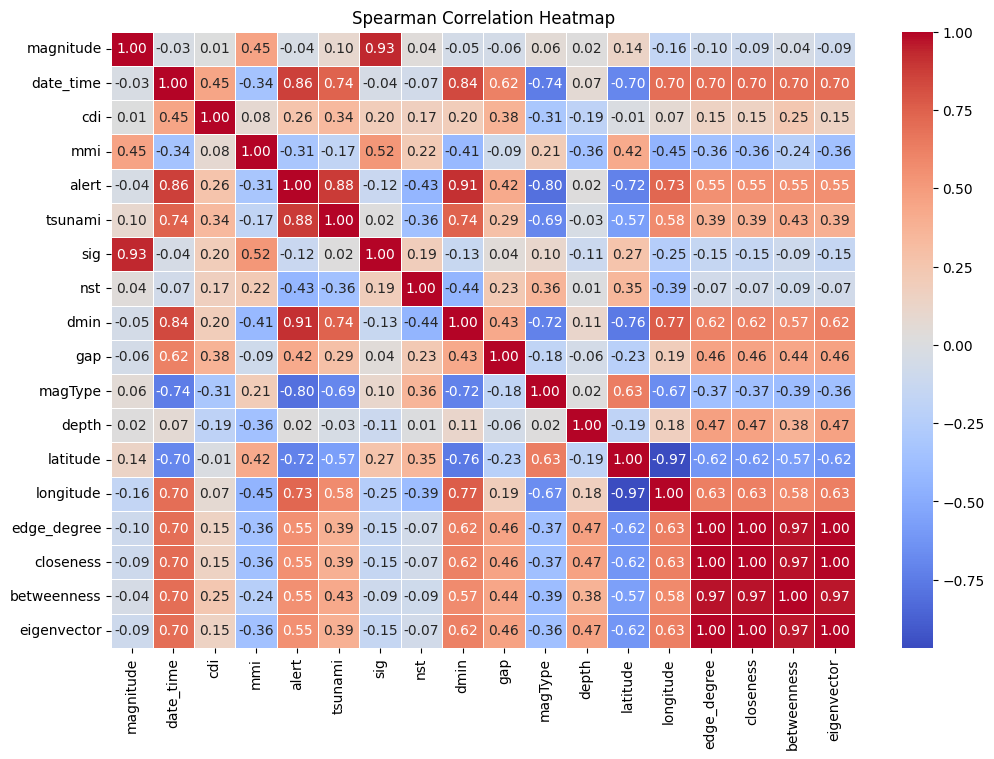

In [59]:
import seaborn as sns

# Filter the DataFrame based on the indices
filtered_df = df.loc[df.index[df.index.isin(top_nodes)]]

# Drop the 'title' and 'net' column from the filtered DataFrame
filtered_df = filtered_df.drop(columns=['title','net'])

# תחילה, ניצור עמודות ריקות עבור כל מדד גרף
filtered_df['edge_degree'] = 0.0
filtered_df['closeness'] = 0.0
filtered_df['betweenness'] = 0.0
filtered_df['eigenvector'] = 0.0

# כעת, נמלא את העמודות עם הערכים המתאימים עבור כל צומת
for node in filtered_df.index:
    filtered_df.at[node, 'edge_degree'] = edge_degrees.get(node, 0)
    filtered_df.at[node, 'closeness'] = closeness.get(node, 0)
    filtered_df.at[node, 'betweenness'] = betweenness.get(node, 0)
    filtered_df.at[node, 'eigenvector'] = eigenvector.get(node, 0)

# Calculate the Spearman correlation matrix
spearman_corr = filtered_df.corr(method='spearman')

# Plot the heatmap of the Spearman correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(spearman_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Spearman Correlation Heatmap')
plt.show()

In [60]:
# Initialize a dictionary to store the top nodes for each period
top_nodes_by_period = {}

# Set the number of top nodes you want to get
top_n = 10

# Analyze centralities for each period and collect the top nodes
for period, G in graphs.items():

    # Compute centrality measures
    edge_degrees, closeness, betweenness, eigenvector = compute_centrality_measures(G)

    # Get top n nodes for each centrality measure
    top_n_edge_degrees = get_top_n_nodes(edge_degrees, top_n)
    top_n_closeness = get_top_n_nodes(closeness, top_n)
    top_n_betweenness = get_top_n_nodes(betweenness, top_n)
    top_n_eigenvector = get_top_n_nodes(eigenvector, top_n)

    # Create a set to store unique top nodes across all centrality measures
    top_nodes_set = set()

    # Collect top nodes (just the node identifiers) from each centrality measure
    top_nodes_set.update([node for node, _ in top_n_edge_degrees])
    top_nodes_set.update([node for node, _ in top_n_closeness])
    top_nodes_set.update([node for node, _ in top_n_betweenness])
    top_nodes_set.update([node for node, _ in top_n_eigenvector])

    # Filter the DataFrame to keep only the rows corresponding to the top nodes
    filtered_df = df.loc[df.index.isin(top_nodes_set)]

    # Save the filtered DataFrame to the dictionary under the current period
    top_nodes_by_period[period] = filtered_df

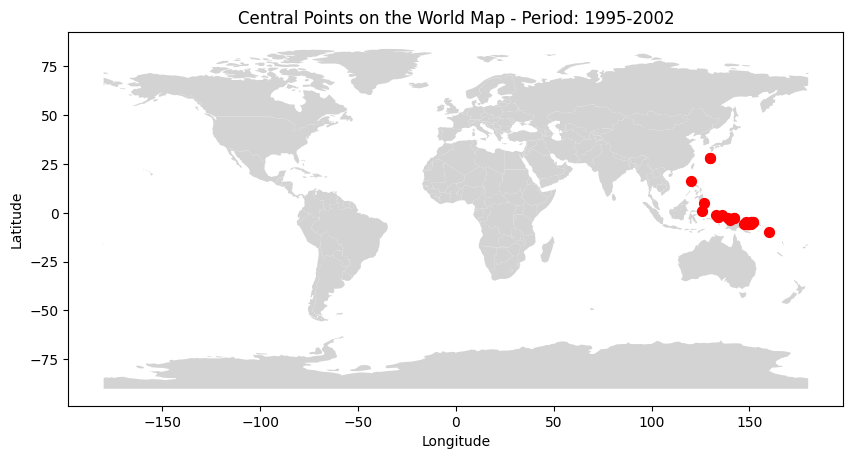

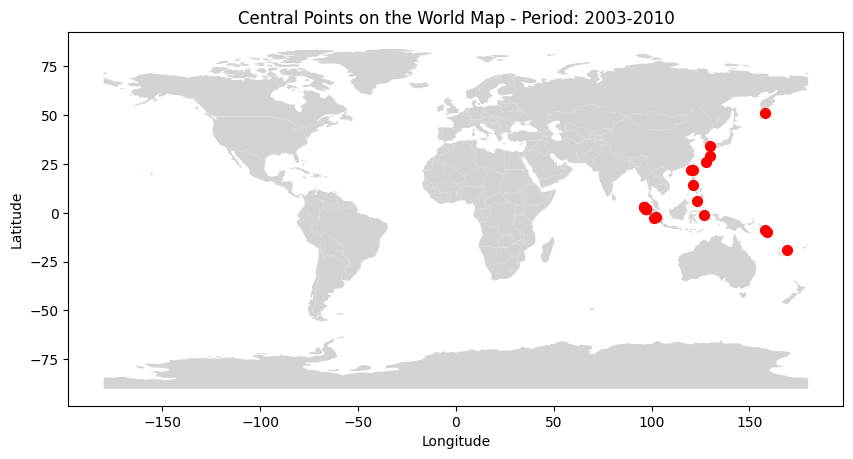

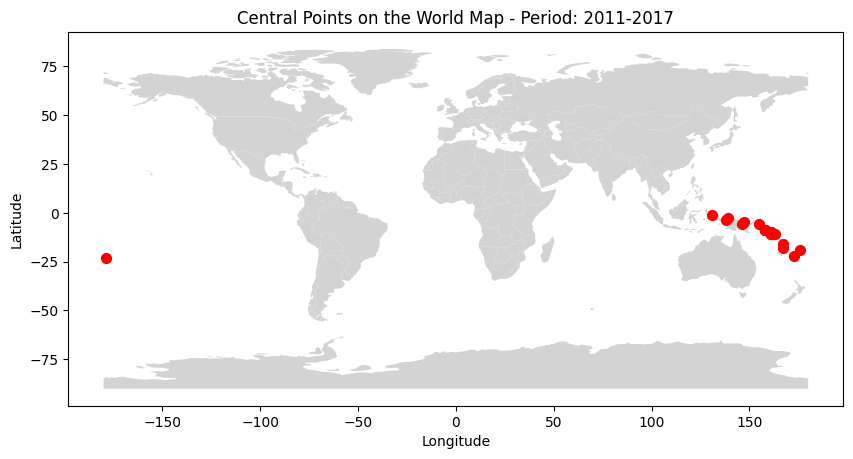

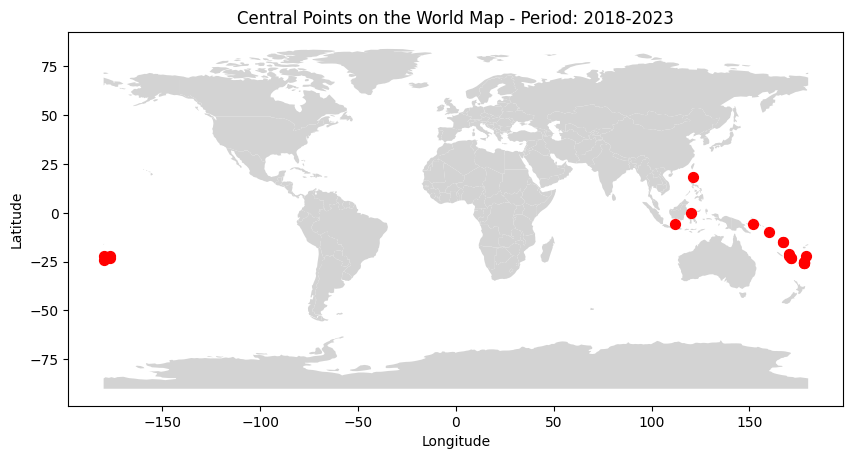

In [61]:
import matplotlib.pyplot as plt
import geopandas as gpd


# Load the world map
file_path = '../ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp'
world = gpd.read_file(file_path)

# Iterate over each period's top nodes DataFrame
for period, top_nodes_df in top_nodes_by_period.items():

    # Create a GeoDataFrame
    gdf = gpd.GeoDataFrame(
        top_nodes_df, geometry=gpd.points_from_xy(top_nodes_df.longitude, top_nodes_df.latitude))

    # Plot the world map
    fig, ax = plt.subplots(figsize=(10, 10))
    world.plot(ax=ax, color='lightgray')

    # Plot the points on the map
    gdf.plot(ax=ax, color='red', markersize=50)

    # Add title and labels
    plt.title(f'Central Points on the World Map - Period: {period}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    # Show the map
    plt.show()

In [62]:
def is_in_ring_of_fire(lat, lon):
    # Northern Hemisphere (Japan to Alaska)
    if 30 <= lat <= 70 and 120 <= lon <= 180:
        return True
    # Eastern Hemisphere (North and South America west coasts)
    elif 0 <= lat <= 60 and -180 <= lon <= -60:
        return True
    # Southern Hemisphere (South America to New Zealand)
    elif -60 <= lat <= 0 and -180 <= lon <= 180:
        return True
    # Western Hemisphere (Southeast Asia to New Zealand)
    elif -30 <= lat <= 30 and 90 <= lon <= 180:
        return True

    return False

In [63]:
for period, data in data_by_period.items():
    # Apply the function to each row in the current DataFrame
    data['in_ring_of_fire'] = data.apply(lambda row: 1 if is_in_ring_of_fire(row['latitude'], row['longitude']) else 0, axis=1)

    # Update the DataFrame back in the dictionary
    data_by_period[period] = data

# Apply the function to each row in the current DataFrame, setting 1 for True and 0 for False
df['in_ring_of_fire'] = df.apply(lambda row: 1 if is_in_ring_of_fire(row['latitude'], row['longitude']) else 0, axis=1)

/tmp/ipykernel_18100/4181671173.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['in_ring_of_fire'] = data.apply(lambda row: 1 if is_in_ring_of_fire(row['latitude'], row['longitude']) else 0, axis=1)
/tmp/ipykernel_18100/4181671173.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['in_ring_of_fire'] = data.apply(lambda row: 1 if is_in_ring_of_fire(row['latitude'], row['longitude']) else 0, axis=1)
/tmp/ipykernel_18100/4181671173.py:3: SettingWithCopyWarning: 
A value is trying to be set on a 

In [64]:
# Iterate over each period and its DataFrame in data_by_period
for period, df in data_by_period.items():
    # Count how many are in the ring of fire
    count_in_ring_of_fire = df[df['in_ring_of_fire'] == 1].shape[0]

    # Count how many are not in the ring of fire
    count_not_in_ring_of_fire = df[df['in_ring_of_fire'] == 0].shape[0]

    # Calculate total count
    total_count = count_in_ring_of_fire + count_not_in_ring_of_fire

    # Calculate the percentage of entries in the ring of fire
    percentage_in_ring_of_fire = (count_in_ring_of_fire / total_count) * 100

    # Print the results
    print(f"Period: {period}")
    print(f"Number of entries in the ring of fire: {count_in_ring_of_fire}")
    print(f"Number of entries not in the ring of fire: {count_not_in_ring_of_fire}")
    print(f"Percentage of entries in the ring of fire: {percentage_in_ring_of_fire:.2f}%")
    print()  # Blank line for better readability

Period: 1995-2002
Number of entries in the ring of fire: 205
Number of entries not in the ring of fire: 31
Percentage of entries in the ring of fire: 86.86%

Period: 2003-2010
Number of entries in the ring of fire: 228
Number of entries not in the ring of fire: 18
Percentage of entries in the ring of fire: 92.68%

Period: 2011-2017
Number of entries in the ring of fire: 270
Number of entries not in the ring of fire: 28
Percentage of entries in the ring of fire: 90.60%

Period: 2018-2023
Number of entries in the ring of fire: 202
Number of entries not in the ring of fire: 18
Percentage of entries in the ring of fire: 91.82%



In [65]:
import community.community_louvain as community_louvain
from networkx.algorithms.community import greedy_modularity_communities, girvan_newman

# Assuming graphs is a dictionary of graph objects
for name, G in graphs.items():
    # 1. Louvain Method
    partition_louvain = community_louvain.best_partition(G)

    # Transform the partition into a list of communities (list of lists)
    communities_louvain = {}
    for node, community in partition_louvain.items():
        communities_louvain.setdefault(community, []).append(node)
    communities_louvain = list(communities_louvain.values())

    modularity_louvain = nx.algorithms.community.modularity(G, communities_louvain)
    print(f"Louvain Modularity for {name}: {modularity_louvain}")

    # 2. Greedy Modularity
    communities_greedy = greedy_modularity_communities(G)
    modularity_greedy = nx.algorithms.community.modularity(G, communities_greedy)
    print(f"Greedy Modularity for {name}: {modularity_greedy}")

    # 3. Girvan-Newman Method
    comp = girvan_newman(G)
    limited = next(comp)  # taking only the first level of division
    modularity_girvan = nx.algorithms.community.modularity(G, limited)
    print(f"Girvan-Newman Modularity for {name}: {modularity_girvan}")

Louvain Modularity for 1995-2002: 0.8985657621116276
Greedy Modularity for 1995-2002: 0.7731885852536997
Girvan-Newman Modularity for 1995-2002: 0.47071721366781605
Louvain Modularity for 2003-2010: 0.8723774479670026
Greedy Modularity for 2003-2010: 0.7007434458810983
Girvan-Newman Modularity for 2003-2010: 0.69591251278098
Louvain Modularity for 2011-2017: 0.9298487567003129
Greedy Modularity for 2011-2017: 0.7690542135974702
Girvan-Newman Modularity for 2011-2017: 0.5451043905025263
Louvain Modularity for 2018-2023: 0.918115939628681
Greedy Modularity for 2018-2023: 0.7783264623460385
Girvan-Newman Modularity for 2018-2023: 0.7746389479529457


In [66]:
import pandas as pd

# יצירת DataFrame מהמידע
data = {
    'Graph': ['1995-2002', '2003-2010', '2011-2017', '2018-2023'],
    'Louvain Modularity': [0.8982825506379326, 0.8729330310758925, 0.9293545520162948, 0.9179214864916808],
    'Greedy Modularity': [0.7731885852536992, 0.7007434458810993, 0.7690542135974703, 0.7783264623460376],
    'Girvan-Newman Modularity': [0.470717213667816, 0.6959125127809811, 0.5451043905025239, 0.7746389479529451]
}

modularity_df = pd.DataFrame(data)
modularity_df.head()

Graph  Louvain Modularity  Greedy Modularity  Girvan-Newman Modularity
0  1995-2002            0.898283           0.773189                  0.470717
1  2003-2010            0.872933           0.700743                  0.695913
2  2011-2017            0.929355           0.769054                  0.545104
3  2018-2023            0.917921           0.778326                  0.774639

In [67]:
from community import community_louvain

# Dictionary to store communities for each graph
communities_dict = {}

# Assuming `graphs` is a dictionary of graph objects keyed by time period
for name, G in graphs.items():
    print(f"Processing {name} graph...")

    # Louvain Method for graphs
    partition_louvain = community_louvain.best_partition(G)

    # Convert partition to list of communities
    communities_louvain = {}
    for node, community in partition_louvain.items():
        if community not in communities_louvain:
            communities_louvain[community] = []
        communities_louvain[community].append(node)

    # Save communities to dictionary
    communities_dict[name] = communities_louvain
    print(f"Communities for {name}: {communities_louvain}")

Processing 1995-2002 graph...
Communities for 1995-2002: {0: [764, 822, 824, 825, 871, 884], 23: [765, 767, 797, 813, 839, 855], 2: [766, 808, 811, 843, 844, 845, 902, 980], 3: [768, 769, 796, 963, 964, 965], 4: [770], 22: [771, 786, 848, 893, 894, 920, 972], 6: [772, 777, 795, 928], 7: [773, 809, 812, 867, 869, 907, 913, 959, 960], 8: [774, 818, 819, 820, 881, 903, 927, 934], 9: [775, 778, 890, 906, 916, 923, 975], 10: [776, 789, 836, 852, 882, 895, 930, 947, 955], 11: [779, 834, 863, 870, 921, 924, 935, 950, 961, 976, 979, 984, 985], 12: [780, 790, 854, 864, 865, 900, 946], 13: [781, 846, 856, 897, 904, 957, 991], 15: [782, 815, 816, 880, 891, 918, 932, 944, 945], 5: [783, 792, 810, 861, 877, 896, 914, 926, 933, 938], 16: [784, 873], 24: [785, 798, 860, 868, 911, 943, 974, 994, 998], 18: [787, 788], 28: [791, 804, 830, 835, 837, 850, 936, 937, 940, 941, 966, 967, 973, 995], 21: [793, 858, 859, 875, 908, 931], 14: [794, 805, 807, 833, 847, 886, 898, 910, 948, 949, 951, 970, 997], 26: 

In [68]:
for period, communities in communities_dict.items():
    print(f"Years: {period} has {len(communities)} communities")

Years: 1995-2002 has 44 communities
Years: 2003-2010 has 40 communities
Years: 2011-2017 has 47 communities
Years: 2018-2023 has 46 communities


In [69]:
for period, clusters in communities_dict.items():
    # Initialize the 'cluster_id' column for the specific period
    data_by_period[period].loc[:, 'cluster_id'] = -1  # Use .loc to modify the DataFrame in place

    # Assign cluster IDs to nodes in the data_by_period DataFrame for each period
    for cluster_id, community in clusters.items():
        for node in community:
            if node in data_by_period[period].index:
                data_by_period[period].loc[node, 'cluster_id'] = cluster_id  # Use .loc to ensure modification is in place

In [70]:
data_by_period[keys_list[0]]

title  magnitude  \
764  M 6.7 - New Ireland region, Papua New Guinea        6.7   
765           M 7.9 - 75 km E of Cantwell, Alaska        7.9   
766       M 7.4 - 50 km NW of Sinabang, Indonesia        7.4   
767         M 6.6 - 53 km ENE of Cantwell, Alaska        6.6   
768       M 6.7 - 72 km S of Manokwari, Indonesia        6.7   
..                                            ...        ...   
995             M 7.1 - 85 km S of Tungor, Russia        7.1   
996        M 7.7 - 249 km E of Vao, New Caledonia        7.7   
997     M 6.9 - 27 km NNW of Maubara, Timor Leste        6.9   
998              M 6.6 - 10 km W of Aianí, Greece        6.6   
999     M 7.1 - 14 km NE of Cabatuan, Philippines        7.1   

              date_time  cdi  mmi  alert  tsunami   sig net  nst  dmin  gap  \
764 2002-12-12 08:30:00    0    6      0        0   691  us  453   0.0  0.0   
765 2002-11-03 22:12:00    8    9      0        0  1750  ak    0   0.0  0.0   
766 2002-11-02 01:26:00    0    7      0        0   842  us  418   0.0  0.0   
767 2002-10-23 11:27:00    0    7      0        0   670  ak    0   0.0  0.0   
768 2002-10-10 12:28:00    0    7      0        0   691  us  250   0.0  0.0   
..                  ...  ...  ...    ...      ...   ...  ..  ...   ...  ...   
995 1995-05-27 13:03:00    0    9      0        0   776  us    0   0.0  0.0   
996 1995-05-16 20:12:00    0    4      0        0   912  us    0   0.0  0.0   
997 1995-05-14 11:33:00    0    6      0        0   732  us    0   0.0  0.0   
998 1995-05-13 08:47:00    0    9      0        0   670  us    0   0.0  0.0   
999 1995-05-05 03:53:00    0    7      0        0   776  us    0   0.0  0.0   

     magType  depth  latitude  longitude  in_ring_of_fire  cluster_id  
764        3   34.0      -5.0      153.0                1           0  
765        5    4.2      64.0     -147.0                0          23  
766        3   30.0       3.0       96.0                1           2  
767        5    4.2      64.0     -148.0                0          23  
768        6   10.0      -2.0      134.0                1           3  
..       ...    ...       ...        ...              ...         ...  
995        3   11.0      53.0      143.0                1          28  
996        5   20.2     -23.0      170.0                1          19  
997        5   11.2      -8.0      125.0                1          14  
998        5   14.0      40.0       22.0                0          24  
999        5   16.0      13.0      125.0                1          20  

[236 rows x 18 columns]

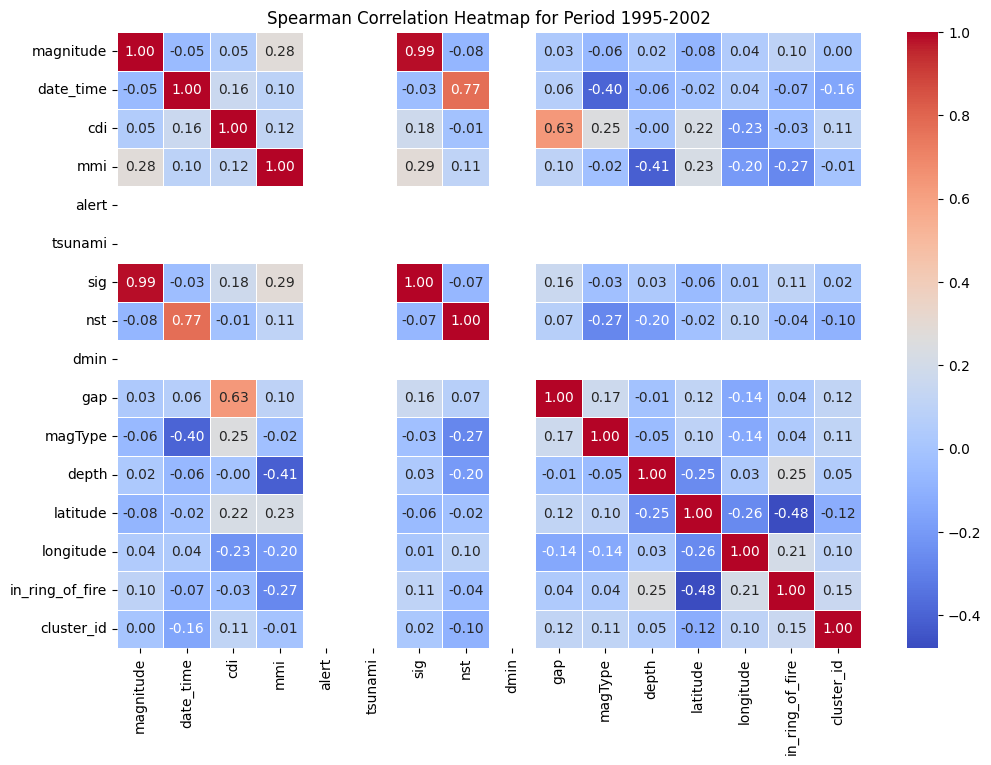

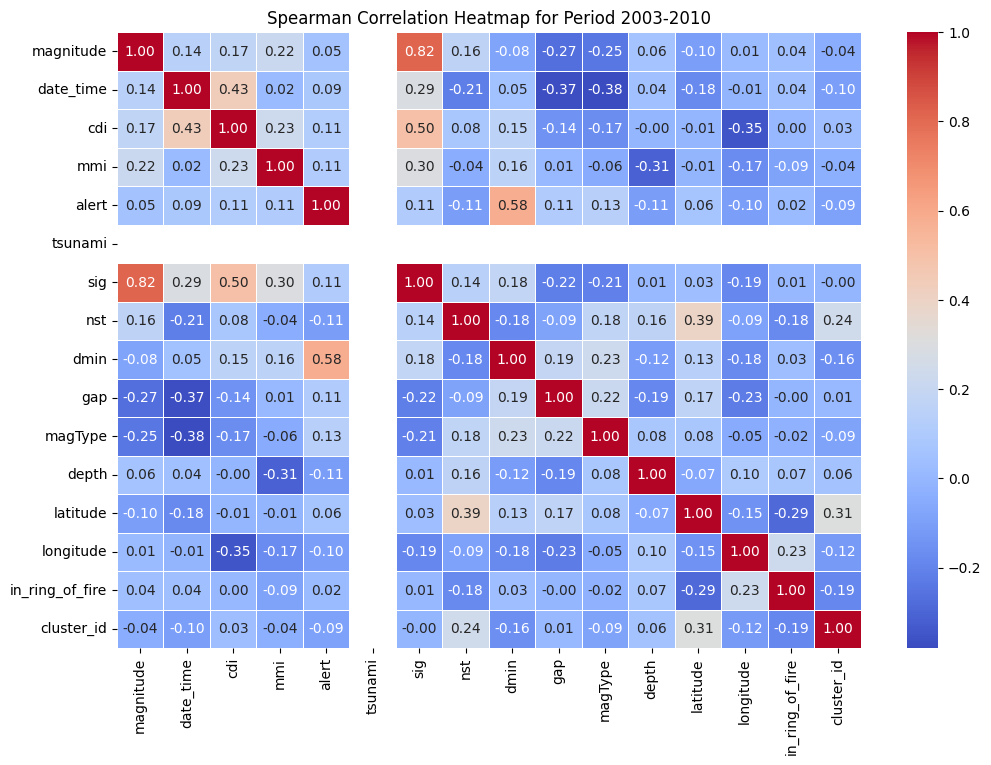

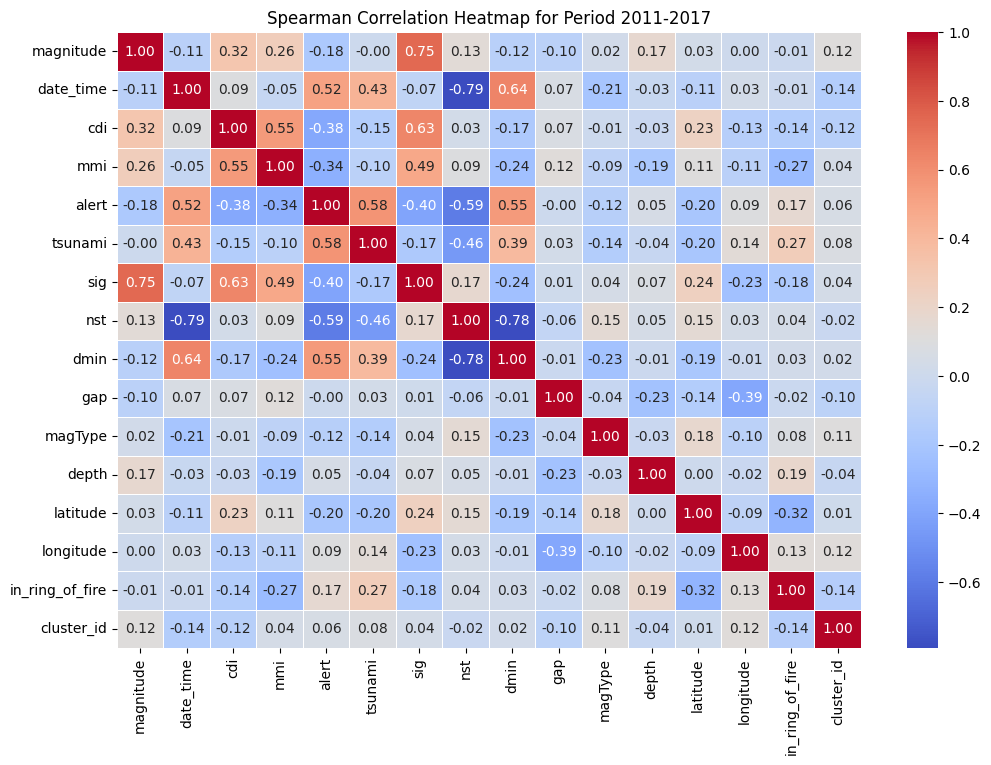

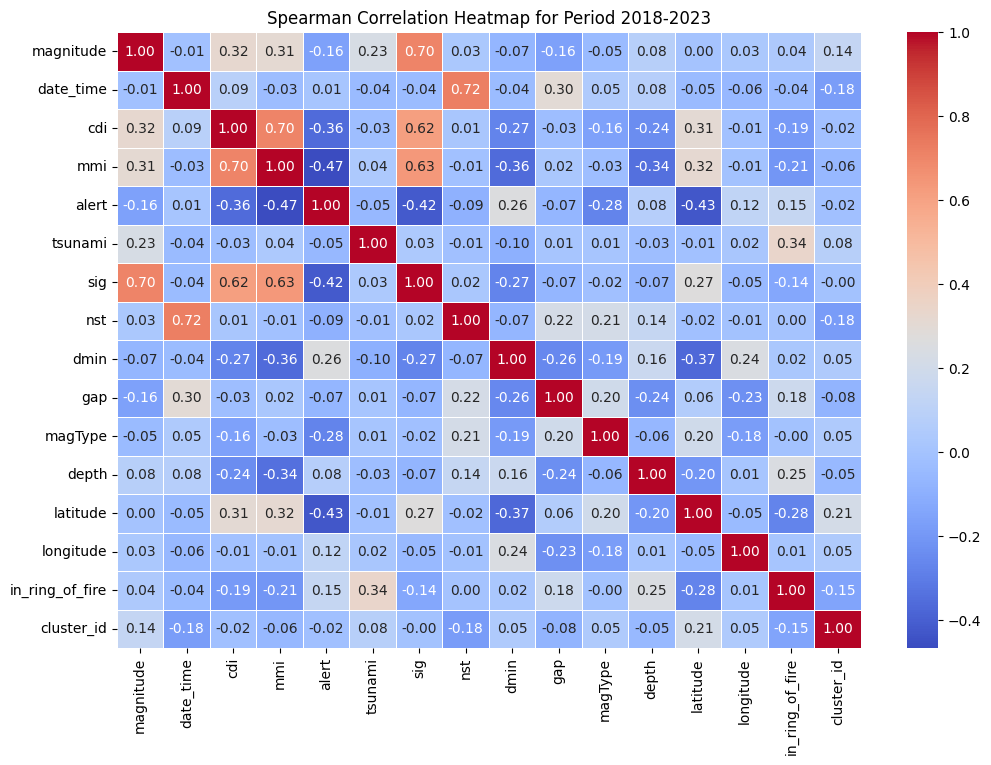

In [71]:
# Loop over each period and its corresponding DataFrame
for period, data in data_by_period.items():

    # Drop the 'title' and 'net' column from the filtered DataFrame
    data = data.drop(columns=['title','net'])

    # Calculate the Spearman correlation matrix
    spearman_corr = data.corr(method="spearman")

    # Plot the heatmap of the Spearman correlation matrix
    plt.figure(figsize=(12, 8))
    sns.heatmap(spearman_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    plt.title(f'Spearman Correlation Heatmap for Period {period}')
    plt.show()

In [72]:
cluster_colors = {
    0: '#33FFFF',
    1: '#FF5733',
    2: '#33FF57',
    3: '#3357FF',
    4: '#FF33A8',
    5: '#A833FF',
    6: '#33FFA8',
    7: '#FF8C33',
    8: '#8C33FF',
    9: '#33FF8C',
    10: '#FF3333',
    11: '#33FF33',
    12: '#3333FF',
    13: '#FF33FF',
    14: '#33FFFF',
    15: '#FFFF33',
    16: '#FF6633',
    17: '#33FF66',
    18: '#6633FF',
    19: '#FF3366',
    20: '#66FF33',
    21: '#3366FF',
    22: '#FFCC33',
    23: '#CC33FF',
    24: '#33FFCC',
    25: '#FF9933',
    26: '#9933FF',
    27: '#33FF99',
    28: '#FF3399',
    29: '#99FF33',
    30: '#3399FF',
    31: '#FF6633',
    32: '#6633FF',
    33: '#33FF66',
    34: '#FF3366',
    35: '#66FF33',
    36: '#3366FF',
    37: '#FF33CC',
    38: '#33FF33',
    39: '#FF33FF',
    40: '#33FFFF',
    41: '#FF33FF',
    42: '#33FFFF',
    43: '#FF3333',
    44: '#33FF33',
    45: '#3333FF',
    46: '#FF33FF'
}

/tmp/ipykernel_18100/3147444327.py:21: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  gdf[gdf["cluster_id"] == cluster_id].plot(ax=ax, color=color, markersize=10)
/tmp/ipykernel_18100/3147444327.py:21: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  gdf[gdf["cluster_id"] == cluster_id].plot(ax=ax, color=color, markersize=10)
/tmp/ipykernel_18100/3147444327.py:21: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  gdf[gdf["cluster_id"] == cluster_id].plot(ax=ax, color=color, markersize=10)


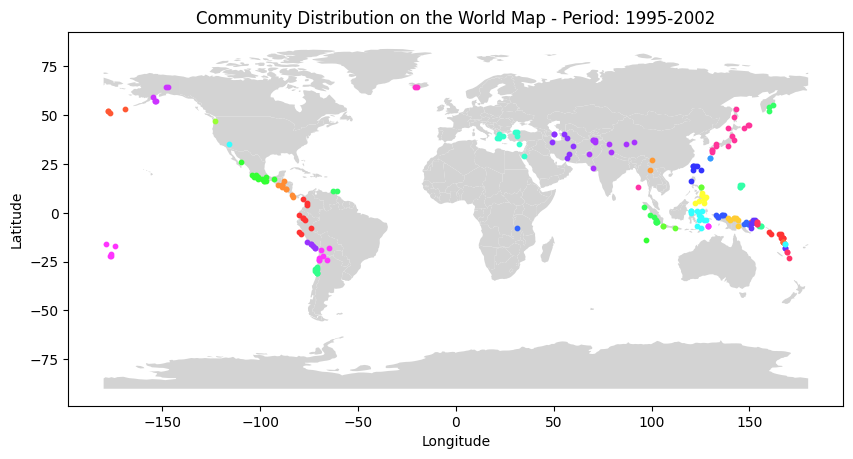

/tmp/ipykernel_18100/3147444327.py:21: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  gdf[gdf["cluster_id"] == cluster_id].plot(ax=ax, color=color, markersize=10)
/tmp/ipykernel_18100/3147444327.py:21: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  gdf[gdf["cluster_id"] == cluster_id].plot(ax=ax, color=color, markersize=10)
/tmp/ipykernel_18100/3147444327.py:21: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  gdf[gdf["cluster_id"] == cluster_id].plot(ax=ax, color=color, markersize=10)
/tmp/ipykernel_18100/3147444327.py:21: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  gdf[gdf["cluster_id"] == cluster_id].plot(ax=ax, color=color, markersize=10)
/tmp/ipykernel_18100/3147444327.py:21: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  gdf[gdf["clu

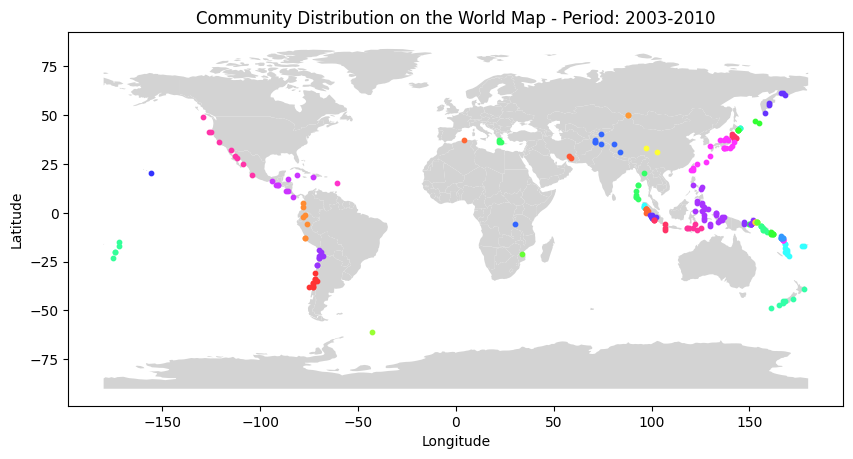

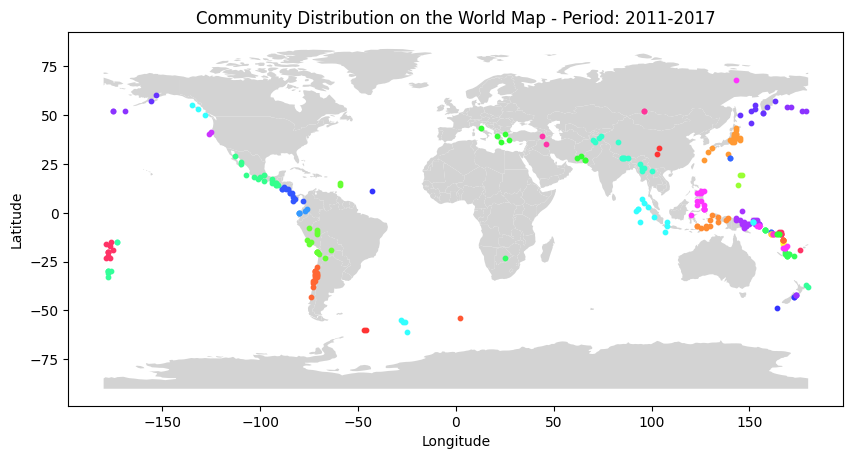

/tmp/ipykernel_18100/3147444327.py:21: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  gdf[gdf["cluster_id"] == cluster_id].plot(ax=ax, color=color, markersize=10)


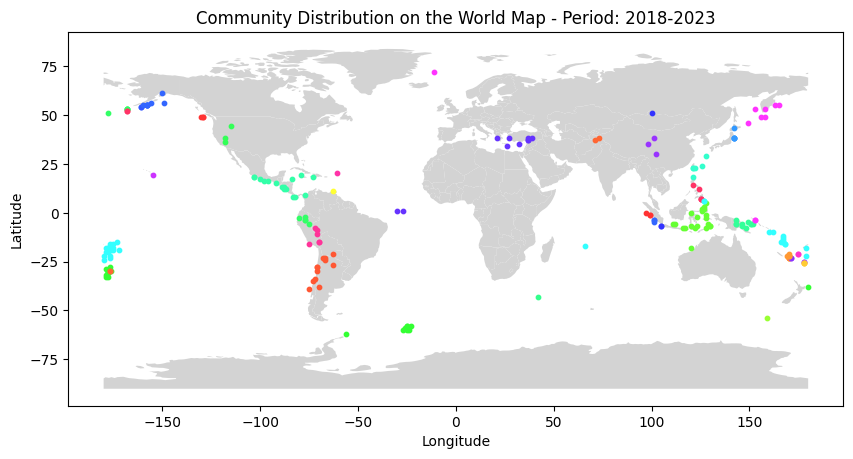

In [74]:
import matplotlib.pyplot as plt
import geopandas as gpd

# Load the world map
file_path = '../ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp'
world = gpd.read_file(file_path)

# Iterate over each period's top nodes DataFrame
for period, data_by_period in data_by_period.items():

    # Create a GeoDataFrame
    gdf = gpd.GeoDataFrame(
        data_by_period, geometry=gpd.points_from_xy(data_by_period.longitude, data_by_period.latitude))

    # Plot the world map
    fig, ax = plt.subplots(figsize=(10, 10))
    world.plot(ax=ax, color='lightgray')

    # Plot all points on the map at once, using the cluster colors
    for cluster_id, color in cluster_colors.items():
        gdf[gdf["cluster_id"] == cluster_id].plot(ax=ax, color=color, markersize=10)

    # Add title and labels
    plt.title(f'Community Distribution on the World Map - Period: {period}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    # Show the map
    plt.show()